# Лабораторная работа №2

## Применение фильтров Габора для формирования вектора признаков в задаче классификации эмоций

Задание к лабораторной работе:

1. Возьмите изображения из папки на диске "images" и файл с метками классов соответствующие 7 эмоциям "dataset.csv" (14 изображений, по 2 изображения для каждого класса)
2. Загрузите необходимые модули и ознакомьтесь с данными (допишите код, где это необходимо)
3. Выполните предобработку данных (допишите код, где это необходимо)
4. Напишите необходимый код для применнеия фильтров Габора с заданными параметрами к изображениям, сормируйте вектор признаков для каждого изображения
5. Попробуйте разобраться какая последовательность действий была выполнена перед извлечением признаков


## **Загрузка данных и необходимых модулей**

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import os
import cv2
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from scipy.ndimage.filters import gaussian_filter
import PIL.Image
import collections
import pylab as pl

/var/folders/0h/0y04mtyd07159mq_zg4f91zh0000gn/T/ipykernel_80984/1000955506.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [4]:
# Загружаем детектор лиц
!pip3 install face_recognition # GPU active needed


  Using cached face_recognition-1.3.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached face_recognition_models-0.3.0.tar.gz (100.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached dlib-19.24.6.tar.gz (3.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached face_recognition-1.3.0-py2.py3-none-any.whl (15 kB)
  Created wheel for dlib: filename=dlib-19.24.6-cp312-cp312-macosx_14_0_universal2.whl size=2917985 sha256=88285a4275bdb3e3889f195f65e315fae05e1473804693787f6f2d74beffa700
  Stored in directory: /Users/uchihaitachi/Library/Caches/pip/wheels/8d/16/b2/d2df2ea5d9430e80343c7b696e9588e5cc98b0d903d434d768
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566165 sha256=dc9ca0ac0d91d369a972f4b9b3dc8f01064a79dd83a5ac7193bf7a

In [32]:
import face_recognition as fr

In [33]:
# Получает список изображений в папке
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [34]:
image_folder = r'images'
img_files_list = getListOfFiles(image_folder)
len(img_files_list)

14

In [36]:
#прочитаем файл с метками классов
'''
0-neutral
1-anger
2-contempt
3-disgust
4-fear
5-happiness
6-surprise
'''
data = pd.read_csv('dataset.csv', index_col=0)
data

,label,file name
0,0,S010_001_00000001.png
1,0,S010_002_00000001.png
2,1,S011_004_00000021.png
3,1,S014_003_00000030.png
4,2,S139_002_00000013.png
5,2,S147_002_00000013.png
6,3,S011_005_00000020.png
7,3,S022_006_00000017.png
8,4,S032_004_00000014.png
9,4,S046_003_00000016.png


In [42]:
emotions = {
0: "neutral",
1: "anger", 
2: "contempt",
3: "disgust",
4: "fear",
5: "happiness",
6: "surprise"}

images/S010_001_00000001.png
images/S011_004_00000021.png
images/S139_002_00000013.png
images/S011_005_00000020.png
images/S032_004_00000014.png
images/S011_006_00000013.png
images/S011_001_00000016.png


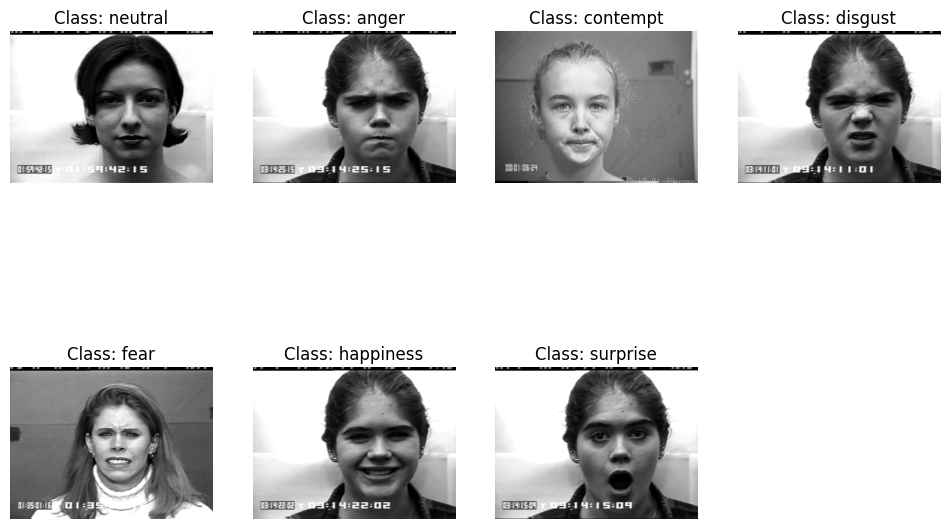

In [44]:
# вывести по одному изображению для каждого класса
unique_labels = data['label'].unique()
plt.figure(figsize=(12, 8))
for i, label in enumerate(unique_labels):
    image = data[data['label'] == label]["file name"].iloc[0]
    image_path = "images/" + image
    print(image_path)
    img = plt.imread(image_path)
    plt.subplot(2, 4, i + 1)  
    plt.imshow(img,cmap='gray')
    plt.title(f'Class: {emotions[label]}')
    plt.axis('off')
plt.show()

## Предобработка изображений

In [161]:
def visualize_1(axs,image,filtered_image,):
  axs[0].imshow(image,cmap='gray')
  axs[0].title.set_text('Оригинальное изображение')
  axs[0].axis('off') 
  axs[1].imshow(filtered_image,cmap='gray')
  axs[1].title.set_text('Обработанное изображение')
  axs[1].axis('off')

def visualize_2(axs,image,filtered_image,i):
  axs[i,0].imshow(image,cmap='gray')
  axs[i,0].title.set_text('Оригинальное изображение')
  axs[i,0].axis('off') 
  axs[i,1].imshow(filtered_image,cmap='gray')
  axs[i,1].title.set_text('Обработанное изображение')
  axs[i,1].axis('off')

def ImagePreProcessing(data, ksize, sigma_GF,IMG_HEIGHT, IMG_WIDTH, visualise_gauss = False, visualise_result = False):
  X = []
  if visualise_gauss or visualise_result:
    fig, axs = plt.subplots(len(data),2,figsize=(10, 5))
  for i,file in enumerate(data['file name'].to_list()):
    image_path = 'images/' + file
    # напишите код применения фильтра Гаусса (с sigma_GF) к изображению выведите одно изображение для примера
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
   
    filtered_image = cv2.GaussianBlur(image, ksize,sigmaX=sigma_GF)
    if visualise_gauss:
      if len(data) < 2:
        visualize_1(axs,image,filtered_image)
      else:
        visualize_2(axs,image,filtered_image,i)

    # Face detection + crop
    face_loc = fr.face_locations(img = filtered_image, model='hog')
    if len(face_loc)>1:
      face_loc=[(face_loc[0])]

    a = collections.deque(*face_loc)
    a.rotate(1)
    shifted = list(a)
    img = PIL.Image.fromarray(filtered_image)
    img2 = img.crop((shifted))
    image_CROPPED = np.array(img2)

    # выполните эквализацию гистограммы с cv2.createCLAHE

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_CLAHE = clahe.apply(image_CROPPED)

    # Scale
    image_SCALED = PIL.Image.fromarray(image_CLAHE).resize((IMG_HEIGHT, IMG_WIDTH))

    X.append(np.array(image_SCALED))
    if visualise_result:
      if len(data) < 2:
        visualize_1(axs,image,image_SCALED)
      else:
        visualize_2(axs,image,image_SCALED,i)
  X = np.array(X)
  return X

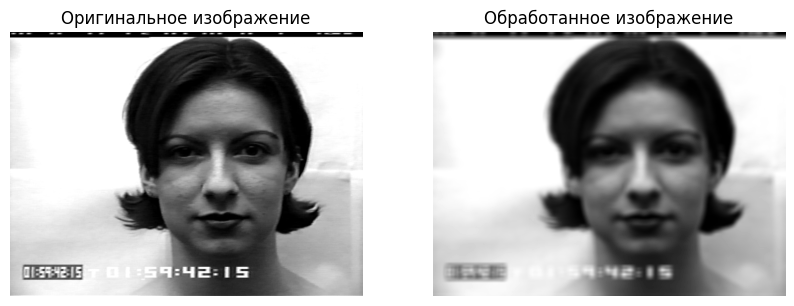

In [263]:
#визуализировать применение фильтра Гаусса к одному изображению (до/после)
_ = ImagePreProcessing(data[:1],(11,11), 11, 64, 64,visualise_gauss=True)

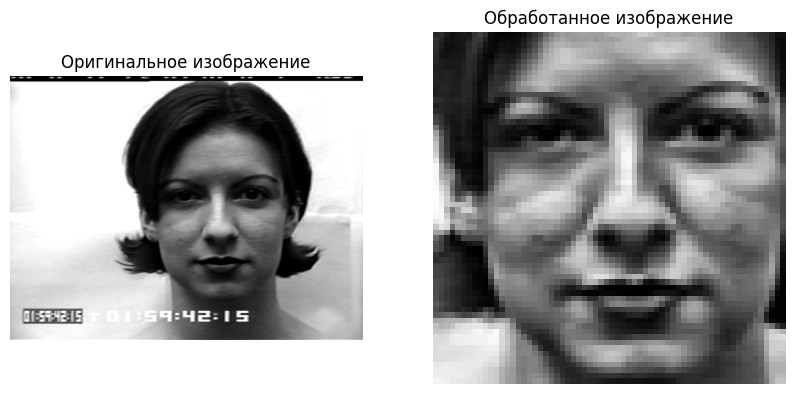

In [162]:
#визуализировать применение эквализации гистограммы к одному изображению (до/после)
_ = ImagePreProcessing(data[:1],(3,3), 1, 64, 64,visualise_result=True)

In [118]:
#применение функции для преобработки данных
image_folder = r'images'
img_files_list = getListOfFiles(image_folder)
X_processed = ImagePreProcessing(data,(3,3), 1, 64, 64)

## **Извлечение признаков с фильтрами Габбора**


In [259]:
# напишите функцию (GaborFiltersFeatures) для создания 8 фильтров Габора (cv2.getGaborKernel) со следующими параметрами
theta_range = np.arange(0, np.pi, np.pi/8)
lamda = 3*np.pi/4
gamma = 0.5
sigma = 0.75 #4.3
ksize = 9
phi = 0
def GaborFiltersFeatures(theta_range,f,gamma,sigma,ksize,nu):
    kmax = np.pi / 2
    x0 = ksize / 2
    y0 = ksize / 2
    F = []

    for mu in theta_range:
        temp_array = np.zeros((ksize, ksize), dtype=complex)
        for x in range(ksize):
            for y in range(ksize):
                k = kmax / (f ** nu)
                omega = mu * (np.pi / 8)
                G = np.exp(-k ** 2 * ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
                S = np.exp(1j * k * ((x - x0) * np.cos(omega) + (y - y0) * np.sin(omega)))
                temp_array[x, y] = G*S

        F.append(temp_array)
    return np.array(F)

X_features = GaborFiltersFeatures(theta_range,lamda,gamma,4.3,ksize,phi)
X_features.shape

(8, 9, 9)

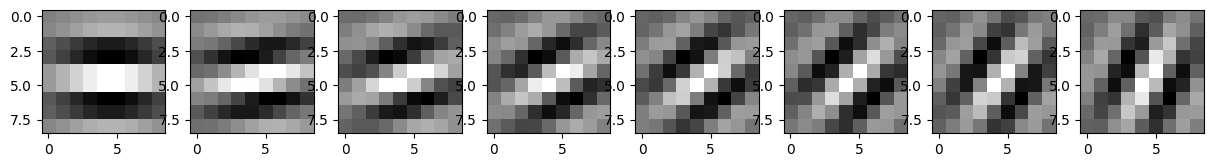

In [260]:
# напишите код для визуализации фильтров Габора с
fig1, axs_1 = plt.subplots(1, 8, figsize=(15, 15))

for j in range(8):
    axs_1[j].imshow(np.real(X_features[j]), cmap='gray')

plt.show()

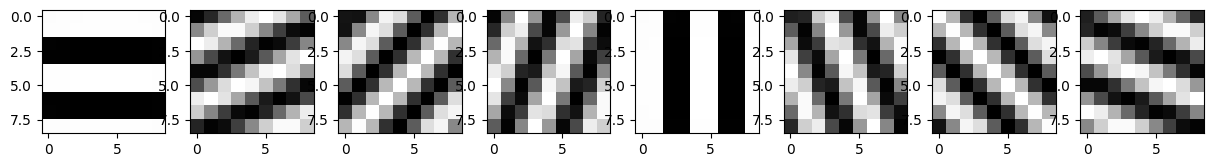

In [253]:
# напишите код для визуализации фильтров Габора с
fig1, axs_1 = plt.subplots(1, 8, figsize=(15, 15))

for j in range(8):
    axs_1[j].imshow(np.real(X_features[j]), cmap='gray')

plt.show()

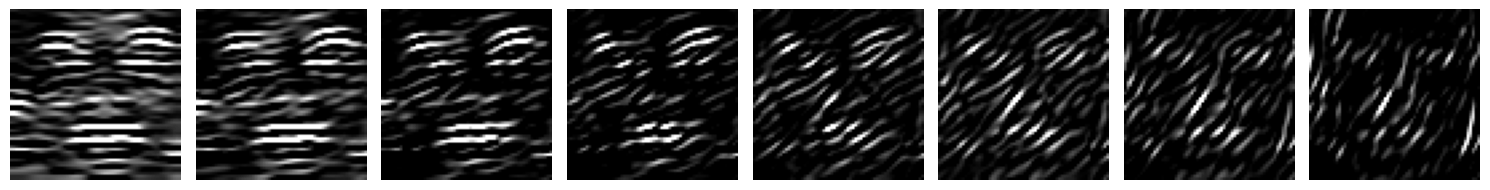

In [261]:
# примените фильтры Габора к любому изображению из датасета, выведите, что получилось (изображения)
fig1, axs_1 = plt.subplots(1, 8, figsize=(15, 15))
image = X_processed[0]

for j in range(8):
    img = cv2.filter2D(src=image, ddepth=-1, kernel=np.real(X_features[j]))
    axs_1[j].imshow(img, cmap='gray')
    axs_1[j].axis('off')
plt.tight_layout()
plt.show()


In [270]:
# примените фильтры Габора к всем изображениям из датасета, выведите размерность матрицы признаков всего датасета
out = []
for image in X_processed:
    for j in range(8):
        out.append(cv2.filter2D(src=image, ddepth=-1, kernel=np.real(X_features[j])))
out = np.array(out)
out = out.reshape(len(X_processed),-1)

In [271]:
out.shape

(14, 32768)

In [266]:
64*64

4096